In [13]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import exp, clip
from IPython import display
# Allowed on piazza
from sklearn.utils import shuffle
from numpy.random import randint
%matplotlib inline

In [38]:
def load_dataset():
    mndata = MNIST('./data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    # The test labels are meaningless,
    # since you're replacing the official MNIST test set with our own test set
    X_test, _ = map(np.array, mndata.load_testing())
    # Remember to center and normalize the data...
    return X_train, labels_train, X_test

X_train, labels_train, X_test = load_dataset()

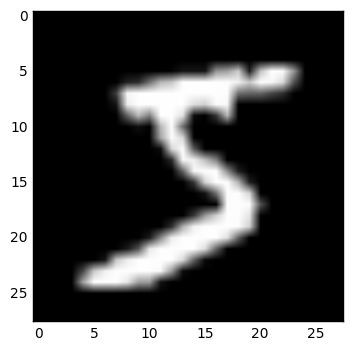

In [39]:
plt.imshow(X_train[0].reshape((28,28)), cmap='Greys_r')

In [211]:
def safe_exp(x):
    """to avoid inf and NaN values"""
    """https://github.com/miha-stopar/nnets/blob/master/neuron/tools.py"""
    return exp(clip(x, -500, 500))
def layerOneActivations(z):
    return np.maximum(z, 0)
def layerOneDeriv(z):
    return np.where(z > 0, 1,0)
def layerTwoActivations(x): 
    e_x = safe_exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
def layerTwoDeriv(layerTwoActivation, y):
    return layerTwoActivation - y
def one_hot(labels_train):     
    '''Convert categorical labels 0,1,2,....9 to standard basis vectors in R^{10} '''     
    return np.eye(10)[labels_train]
def computeCostAndAccuracy(inputDataset, labels):
    inputDataset = np.hstack((inputDataset, np.ones((inputDataset.shape[0],1))))
    hiddenLayerWeightedInput = weights[0].dot(inputDataset.T)
    hiddenLayerActivation = np.vstack((g[0](hiddenLayerWeightedInput), np.ones((1,hiddenLayerWeightedInput.shape[1]))))

    outputLayerWeightedInput = weights[1].dot(hiddenLayerActivation)
    outputLayerActivation = g[1](outputLayerWeightedInput).T
    
    #digitPredictions = np.diag(np.array([range(10)])).dot(outputLayerActivation)
    digitPredictions = np.argmax(outputLayerActivation, axis=1)
    labelsConverted = np.argmax(labels, axis=1)
    theCost = -(outputLayerActivation * np.log(labels + 1e-200)).sum()
    accuracy = np.sum(labelsConverted==digitPredictions) / len(labelsConverted)
    return theCost, accuracy

In [334]:
n_in = 784
n_hid = 200
n_out = 10
n_layers = 3

# Param for layer k exists in array position k-1
# i.e. [V,W]
g = [layerOneActivations, layerTwoActivations]
g_prime = [layerOneDeriv, layerTwoDeriv]
weights = [np.random.randn(n_hid, n_in+1)/np.sqrt(n_hid), np.random.randn(n_out, n_hid+1)/np.sqrt(n_out)]

train_size = 50000
validate_size = 10000
labels, inputData = shuffle(one_hot(labels_train), X_train)
# 1 epoch approx 30 sec
# num_iters = int(40 * train_size)
num_iters = 50000
# compute_cost_interval = int(np.sqrt(num_iters))
compute_cost_interval = 10000

trainLabels, trainData = labels[train_size:], inputData[train_size:]
validateLabels, validateData = labels[:validate_size], inputData[:validate_size]

# Save costs here
trainingCostList, validationCostList = np.array([]), np.array([])
trainingAccuracyList, validationAccuracyList = np.array([]), np.array([])

# Hyperparameters
initialLearningRate = 1e-3
decayFactor = (initialLearningRate / num_iters) * 1e-2
for i in range(num_iters):
    learningRate = 1e-3
#     learningRate = initialLearningRate / (1 + i / num_iters)
    
    # Select a random point
    datapointIndex = randint(0, len(trainLabels))
    inputVector = np.append(trainData[datapointIndex], [1])
    labelVector = trainLabels[datapointIndex]

    # Feed forward
    hiddenLayerWeightedInput = weights[0].dot(inputVector)
    hiddenLayerActivation = np.append(g[0](hiddenLayerWeightedInput), [1])

    outputLayerWeightedInput = weights[1].dot(hiddenLayerActivation)
    outputLayerActivation = g[1](outputLayerWeightedInput)

    # Compute cost (don't do every time)
    if i % compute_cost_interval == 0:
        tCost, tAccuracy = computeCostAndAccuracy(trainData, trainLabels)
        trainingCostList = np.append(trainingCostList, tCost)
        trainingAccuracyList = np.append(trainingAccuracyList, tAccuracy)
        
        vCost, vAccuracy = computeCostAndAccuracy(validateData, validateLabels)
        validationCostList = np.append(validationCostList, vCost)
        validationAccuracyList = np.append(validationAccuracyList, vAccuracy)

    # Update outer weights
    # W
    deltaW = outputLayerActivation - labelVector
    dW = np.outer(deltaW,hiddenLayerActivation)

    # V
    deltaV = g_prime[0](hiddenLayerWeightedInput) * weights[1].T.dot(deltaW)[:-1]
    dV = np.outer(deltaV, inputVector)
#     deltaV = g_prime[0](hiddenLayerWeightedInput)
#     print(weights[1].T.dot(deltaW)[:-1].shape)
#     dV = deltaV * weights[1].T.dot(deltaW)[:-1] + momentumFactor * prevDv
#     prevDv = dV
    
#     print(weights[0].shape, weights[1].shape)
#     print(dV.shape, dW.shape)
    
    assert weights[0].shape == dV.shape
    assert weights[1].shape == dW.shape
    
    # Update weights
    # W
    weights[1] -= learningRate*dW
    # V
    weights[0] -= learningRate*dV
# Normalize costs for comparison
# validationCost /= len(validateLabels)
# trainingCost /= len(trainLabels)

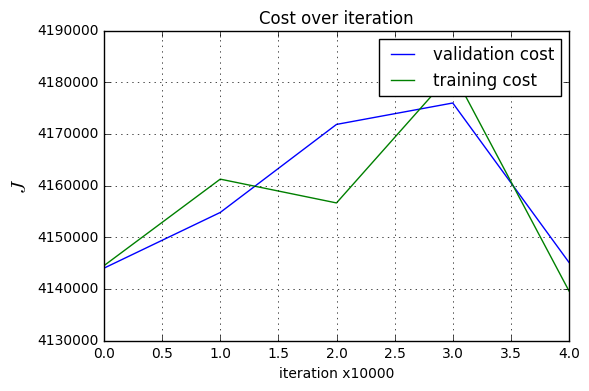

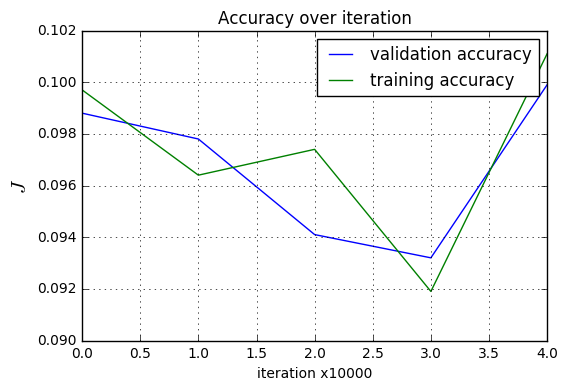

In [335]:
# Plot the cost over the iterations
plt.figure(1)
# plt.subplot(211)
validationCostPlot = plt.plot(validationCostList, label="validation cost")[0]
trainingCostPlot = plt.plot(trainingCostList, label="training cost")[0]
plt.xlabel('iteration x' + str(compute_cost_interval))
plt.ylabel('$J$', fontsize=15)
plt.title('Cost over iteration')
plt.grid()
plt.legend()
# Plot the accuracy over the iterations
# plt.subplot(212)
plt.figure(2)
validationAccuracyPlot = plt.plot(validationAccuracyList, label="validation accuracy")[0]
trainingAccuracyPlot = plt.plot(trainingAccuracyList, label="training accuracy")[0]
plt.xlabel('iteration x' + str(compute_cost_interval))
plt.ylabel('$J$', fontsize=15)
plt.title('Accuracy over iteration')
plt.grid()
plt.legend()